# **Cipher-10**

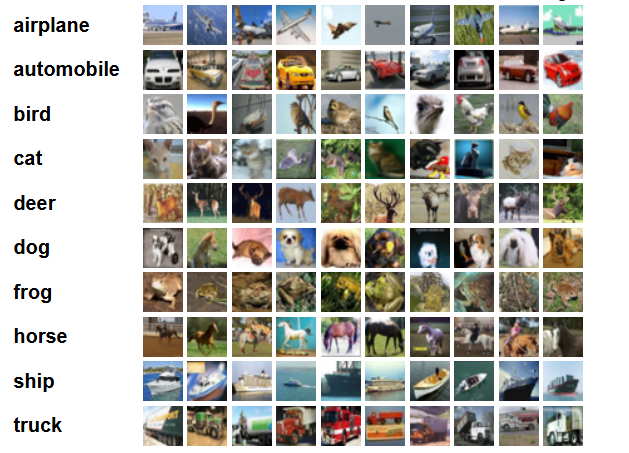

In [1]:
import os
folder_dir = "/kaggle/working/"

## **Importing Libraries**
<details>
<summary> <b>Libraries</b></summary>
  
- **`tensorflow`** and **`tensorflow.keras.utils`** for building and training deep learning models.    
- **`sklearn`** for dataset.  
- **`numpy`** for efficient numerical computations.

</details>


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

2025-04-27 06:27:35.832642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745735256.080443      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745735256.150964      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Loading CIFAR-10 Dataset**

Loading CIFAR-10 dataset directly from Keras datasets module and splitting it into training and test sets.

<details>
<summary> <b>Dataset Details</b> </summary>

- **Training Set:** 50,000 images
- **Test Set:** 10,000 images
- **Image Shape:** (32, 32, 3) — RGB color images
- **Number of Classes:** 10

</details>


In [3]:
# Load CIFAR-10 dataset
(x_train_part, y_train_part), (x_test_part, y_test_part) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


## **Dataset Preparation**
Prepare the full dataset by merging, normalizing, encoding, and splitting into train, validation, and test sets.

<details>
<summary> <b>Steps Involved</b> </summary>

- **Concatenation**: Combined `x_train_part` and `x_test_part` to form a full dataset (`60000` samples).
- **Normalization**: Scaled pixel values to the range `[0, 1]` by dividing by `255.0`.
- **One-Hot Encoding**: Converted class labels into one-hot vectors using `to_categorical` for `10` classes.
- **First Split**: Divided the full dataset into `70%` training and `30%` temporary set (for validation and testing) using `train_test_split`.
- **Second Split**: Further divided the temporary set equally into validation (`15%`) and test (`15%`) sets.
- **Verification**: Printed the final shapes of `x_train`, `x_val`, and `x_test` to confirm correct partitioning.

</details>


In [4]:
# Concatenate all data to create full dataset (60000 samples)
x_full = np.concatenate((x_train_part, x_test_part), axis=0) / 255.0
y_full = np.concatenate((y_train_part, y_test_part), axis=0)

# One-hot encode the labels
y_full = to_categorical(y_full, 10)

# First split: train (70%) vs temp (30%)
x_train, x_temp, y_train, y_temp = train_test_split(x_full, y_full, test_size=0.30, random_state=42, stratify=y_full)

# Second split: validation (15%) vs test (15%) from temp
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print final shapes
print("Total samples:", x_full.shape[0])
print("Training set:", x_train.shape)
print("Validation set:", x_val.shape)
print("Test set:", x_test.shape)

Total samples: 60000
Training set: (42000, 32, 32, 3)
Validation set: (9000, 32, 32, 3)
Test set: (9000, 32, 32, 3)


## **Model Architecture: MLP Design**
Definition of a customizable Multi-Layer Perceptron (MLP) model with optional batch normalization and regularization techniques.

<details>
<summary> <b>Model Components</b> </summary>

- **Input Layer**:
  - `Flatten` layer to reshape the input of shape `(32, 32, 3)` into a 1D vector.
  
- **Hidden Layers**:
  - Multiple `Dense` layers based on the `hidden_layers` list (`[128, 64]` by default).
  - `ReLU` activation function for non-linearity.
  - `L2 regularization` applied to each dense layer using `regularizers.l2(l2_reg)`.
  - **Optional**: `BatchNormalization` layer added after each dense layer if `use_batchnorm=True`.
  - `Dropout` layer applied after each hidden block to prevent overfitting (`dropout_rate=0.5` by default).

- **Output Layer**:
  - `Dense` layer with `10` units and `softmax` activation for multi-class classification on CIFAR-10 dataset.

- **Model Type**:
  - Built using `tf.keras.Sequential` API for stacking layers sequentially.

</details>


In [5]:
from tensorflow.keras import layers, models, regularizers

def create_mlp_model(input_shape=(32, 32, 3),
                     hidden_layers=[128, 64],
                     l2_reg=0.001,
                     dropout_rate=0.5,
                     use_batchnorm=True):

    model = models.Sequential()

    # Input flattening
    model.add(layers.Flatten(input_shape=input_shape))

    # Hidden layers
    for units in hidden_layers:
        # Dense layer with L2 regularization
        model.add(layers.Dense(units,
                               activation='relu',
                               kernel_regularizer=regularizers.l2(l2_reg)))
        # Optional: Batch Normalization
        if use_batchnorm:
            model.add(layers.BatchNormalization())

        # Dropout
        model.add(layers.Dropout(dropout_rate))

    # Output layer - 10 classes for CIFAR-10
    model.add(layers.Dense(10, activation='softmax'))

    return model


In [6]:
model = create_mlp_model(use_batchnorm=True)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-27 06:28:05.072598: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         393,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 403,018 (1.54 MB)

 Trainable params: 402,634 (1.54 MB)

 Non-trainable params: 384 (1.50 KB)

## **Model Training & Saving**
Function to train a new MLP model with a specified optimizer and save it if it does not already exist.

<details>
<summary> <b>Process Overview</b> </summary>

- **Model Saving Path**:
  - Constructs the full model path by combining `save_dir` and a model filename based on `model_name` and `optimizer_name`.
  
- **Check for Existing Model**:
  - If the model file does not exist, proceeds to training.
  - If already exists, skips training and prints a message.

- **Model Creation**:
  - Calls `create_mlp_model` with customizable parameters (e.g., `input_shape`, `hidden_layers`, `l2_reg`, `dropout_rate`, `use_batchnorm`).

- **Optimizer Selection**:
  - Dynamically selects the optimizer (`SGD`, `Adam`, `RMSprop`, `Adagrad`) based on the `optimizer_name` input.

- **Model Compilation**:
  - Compiles the model with `categorical_crossentropy` loss and `accuracy` as the evaluation metric.

- **Model Training**:
  - Trains the model on `x_train` and `y_train`.
  - Validates performance using `x_val` and `y_val`.
  - Uses specified `batch_size` and `epochs`.

- **Model Saving**:
  - Creates the `save_dir` if it does not exist.
  - Saves the trained model in `.keras` format at the designated path.

</details>


In [7]:
import os

def train_and_save_model(optimizer_name='adam',
                         model_name='mlp_model',
                         input_shape=(32, 32, 3),
                         hidden_layers=[128, 64],
                         l2_reg=0.001,
                         dropout_rate=0.5,
                         use_batchnorm=True,
                         batch_size=64,
                         epochs=50,
                         save_dir= folder_dir + 'MLP_Models'):

    # path to save the model
    model_path = os.path.join(save_dir, model_name + '_' + optimizer_name + '.keras')

    # if the model has not been created before
    if not os.path.exists(model_path):
        print(f"Training new model with optimizer: {optimizer_name}")

        # create the model
        model = create_mlp_model(input_shape=input_shape,
                                 hidden_layers=hidden_layers,
                                 l2_reg=l2_reg,
                                 dropout_rate=dropout_rate,
                                 use_batchnorm=use_batchnorm)

        # select optimizer by name
        if optimizer_name.lower() == 'sgd':
            optimizer = tf.keras.optimizers.SGD()
        elif optimizer_name.lower() == 'adam':
            optimizer = tf.keras.optimizers.Adam()
        elif optimizer_name.lower() == 'rmsprop':
            optimizer = tf.keras.optimizers.RMSprop()
        elif optimizer_name.lower() == 'adagrad':
            optimizer = tf.keras.optimizers.Adagrad()
        else:
            raise ValueError("Unsupported optimizer")

        # compile the model
        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # model training
        history = model.fit(x_train, y_train,
                            validation_data=(x_val, y_val),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=2)

        # save the model
        os.makedirs(save_dir, exist_ok=True)
        model.save(model_path)
        print(f"Model saved to {model_path}")

    else:
        print(f"Model already exists at {model_path}, skipping training.")


In [8]:
# Training with Adam
train_and_save_model(optimizer_name='adam')

# Training with SGD
train_and_save_model(optimizer_name='sgd')

# Training with RMSprop
train_and_save_model(optimizer_name='rmsprop')

# Training with Adagrad
train_and_save_model(optimizer_name='adagrad')


Training new model with optimizer: adam
Epoch 1/50
657/657 - 9s - 13ms/step - accuracy: 0.2455 - loss: 2.4773 - val_accuracy: 0.2744 - val_loss: 2.1438
Epoch 2/50
657/657 - 4s - 7ms/step - accuracy: 0.2880 - loss: 2.1245 - val_accuracy: 0.3161 - val_loss: 2.0325
Epoch 3/50
657/657 - 4s - 7ms/step - accuracy: 0.3037 - loss: 2.0331 - val_accuracy: 0.3003 - val_loss: 2.0219
Epoch 4/50
657/657 - 4s - 7ms/step - accuracy: 0.2987 - loss: 2.0154 - val_accuracy: 0.3267 - val_loss: 1.9101
Epoch 5/50
657/657 - 5s - 7ms/step - accuracy: 0.2888 - loss: 2.0133 - val_accuracy: 0.3250 - val_loss: 1.9236
Epoch 6/50
657/657 - 5s - 7ms/step - accuracy: 0.2923 - loss: 2.0030 - val_accuracy: 0.1623 - val_loss: 7.0019
Epoch 7/50
657/657 - 4s - 7ms/step - accuracy: 0.2933 - loss: 2.0014 - val_accuracy: 0.2621 - val_loss: 2.1304
Epoch 8/50
657/657 - 5s - 7ms/step - accuracy: 0.2963 - loss: 1.9855 - val_accuracy: 0.2690 - val_loss: 2.0718
Epoch 9/50
657/657 - 4s - 7ms/step - accuracy: 0.2966 - loss: 1.9867 - 

## **Grid Search for Hyperparameter Tuning**
Implementation of an automated grid search to find the best hyperparameters for the MLP model based on validation accuracy.

<details>
<summary> <b>Components and Workflow</b> </summary>

- **Best Parameters Retrieval**:
  - `best_parms_val_acc()` checks if a previously saved best parameters file (`best_params.txt`) exists.
  - Loads the best validation accuracy and parameters if available.

- **Grid Search Execution**:
  - Iterates through combinations of:
    - **Optimizers**: `['adam', 'sgd']`
    - **Learning Rates**: `[0.001, 0.0005]`
    - **L2 Regularization Values**: `[0.0001, 0.001]`
    - **Dropout Rates**: `[0.3, 0.5]`
  - Trains an MLP model for each combination.
  - Compiles models with `categorical_crossentropy` loss and tracks `accuracy`.

- **Optimizer Selection**:
  - `get_optimizer(name, learning_rate)` returns an optimizer instance based on name and learning rate.
  - Supports `Adam`, `SGD`, `RMSprop`, and `Adagrad`.

- **Model Saving and Evaluation**:
  - Each trained model is saved individually into the specified `save_dir`.
  - Validation accuracy is calculated at the end of training.
  - If a new best validation accuracy is found:
    - Updates `best_val_acc` and `best_params`.
    - Saves the updated best parameters into a JSON file.

- **Final Output**:
  - After search completion, prints and returns the best hyperparameters found.

</details>


In [9]:
import json

save_dir= folder_dir + "MLP_CIFAR10_Models"
best_params_file = os.path.join(save_dir, "best_params.txt")
best_val_acc = 0.0
best_params = None
def best_parms_val_acc():
  if os.path.exists(best_params_file):
      with open(best_params_file, 'r') as f:
          saved = json.load(f)
          best_val_acc = saved.get('best_val_acc', 0.0)
          best_params = saved.get('best_params', None)
      print(f"📂 Loaded previous best_val_acc: {best_val_acc:.4f}")
      print(f"⚙️ Loaded best_params: {best_params}")
  else:
      best_val_acc = 0.0
      best_params = None

  return best_params, best_val_acc


In [10]:
def perform_grid_search(
    input_shape,
    hidden_layers=[128, 64],
    l2_vals=[0.0001, 0.001],
    dropout_vals=[0.3, 0.5],
    learning_rates=[0.001, 0.0005],
    optimizers=['adam', 'sgd'],
    batch_size=64,
    epochs=50,
    use_batchnorm=True,
    save_dir=folder_dir+"MLP_CIFAR10_Models"
):
    global best_val_acc, best_params

    best_params, best_val_acc = best_parms_val_acc()
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for optimizer_name in optimizers:
        for lr in learning_rates:
            for l2_reg in l2_vals:
                for dropout_rate in dropout_vals:
                    model_name = f"mlp_opt-{optimizer_name}_lr-{lr}_dr-{dropout_rate}_l2-{l2_reg}.keras"
                    model_path = os.path.join(save_dir, model_name)

                    if os.path.exists(model_path):
                        print(f"✅ Model already exists: {model_name}")
                        print(best_params)
                        continue

                    print(f"🚀 Training: {model_name}")

                    model = create_mlp_model(
                        input_shape=input_shape,
                        hidden_layers=hidden_layers,
                        l2_reg=l2_reg,
                        dropout_rate=dropout_rate,
                        use_batchnorm=use_batchnorm
                    )

                    optimizer = get_optimizer(optimizer_name, lr)
                    model.compile(optimizer=optimizer,
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

                    history = model.fit(
                        x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        verbose=0
                    )

                    val_acc = history.history['val_accuracy'][-1]
                    print(f"📈 Final val_accuracy: {val_acc:.4f}")

                    if val_acc > best_val_acc:
                        best_val_acc = val_acc
                        best_params = {
                            'optimizer': optimizer_name,
                            'learning_rate': lr,
                            'l2_reg': l2_reg,
                            'dropout_rate': dropout_rate,
                            'model_path': model_path
                        }

                        # Find the best parameters in a text file.
                        with open(best_params_file, 'w') as f:
                            json.dump({
                                'best_val_acc': best_val_acc,
                                'best_params': best_params
                            }, f, indent=4)

                        # Save only the best model
                        # model_name = "WasBest" + model_name
                        # model.save(os.path.join(save_dir, model_name))

                    model.save(model_path)

    if best_params is not None:
        print("🏆 Best Params:", best_params)
    else:
        print("❌ No model was trained.")

    return best_params


In [11]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad

def get_optimizer(name, learning_rate):
    if name.lower() == 'adam':
        return Adam(learning_rate=learning_rate)
    elif name.lower() == 'sgd':
        return SGD(learning_rate=learning_rate)
    elif name.lower() == 'rmsprop':
        return RMSprop(learning_rate=learning_rate)
    elif name.lower() == 'adagrad':
        return Adagrad(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer: {name}")

In [12]:
# define input_shape
input_shape = x_train.shape[1:]

# run Grid Search
best_params = perform_grid_search(input_shape=input_shape)


🚀 Training: mlp_opt-adam_lr-0.001_dr-0.3_l2-0.0001.keras
📈 Final val_accuracy: 0.4446
🚀 Training: mlp_opt-adam_lr-0.001_dr-0.5_l2-0.0001.keras
📈 Final val_accuracy: 0.3771
🚀 Training: mlp_opt-adam_lr-0.001_dr-0.3_l2-0.001.keras
📈 Final val_accuracy: 0.2918
🚀 Training: mlp_opt-adam_lr-0.001_dr-0.5_l2-0.001.keras
📈 Final val_accuracy: 0.2811
🚀 Training: mlp_opt-adam_lr-0.0005_dr-0.3_l2-0.0001.keras
📈 Final val_accuracy: 0.4630
🚀 Training: mlp_opt-adam_lr-0.0005_dr-0.5_l2-0.0001.keras
📈 Final val_accuracy: 0.4026
🚀 Training: mlp_opt-adam_lr-0.0005_dr-0.3_l2-0.001.keras
📈 Final val_accuracy: 0.4256
🚀 Training: mlp_opt-adam_lr-0.0005_dr-0.5_l2-0.001.keras
📈 Final val_accuracy: 0.2949
🚀 Training: mlp_opt-sgd_lr-0.001_dr-0.3_l2-0.0001.keras
📈 Final val_accuracy: 0.4690
🚀 Training: mlp_opt-sgd_lr-0.001_dr-0.5_l2-0.0001.keras
📈 Final val_accuracy: 0.4324
🚀 Training: mlp_opt-sgd_lr-0.001_dr-0.3_l2-0.001.keras
📈 Final val_accuracy: 0.4723
🚀 Training: mlp_opt-sgd_lr-0.001_dr-0.5_l2-0.001.keras
📈 F

## **Model Loading, Prediction, and Evaluation**
This section focuses on loading the best model, making predictions, and evaluating model performance using various metrics.

<details>
<summary> <b>Components and Workflow</b> </summary>

- **Model Loading**:
  - `load_best_model()`:
    - Constructs the model filename based on the best hyperparameters found.
    - Loads the saved `.keras` model file if it exists.
    - If the model file is missing, a warning is printed.

- **Prediction**:
  - `Prediction_of_test_dataset(model)`:
    - Predicts probabilities for the test dataset.
    - Converts predicted probabilities into class labels using `argmax`.

- **Evaluation**:
  - `evaluate_model(y_true, y_pred, best_params, input_shape, hidden_layers)`:
    - Computes key performance metrics:
      - **Accuracy**
      - **Precision** (macro average)
      - **Recall** (macro average)
      - **F1 Score** (macro average)
      - **F2 Score** (macro average)
    - Displays:
      - Confusion Matrix
      - Classification Report
    - Returns a dictionary containing all calculated metrics.

- **Summary**:
  - The best model's performance is evaluated separately from the normal model.
  - Both prediction results (`y_pred`, `y_pred_best`) are analyzed.

</details>


In [13]:
def load_best_model():
   # Generate model name
    model_name = f"mlp_opt-{best_params['optimizer']}_lr-{best_params['learning_rate']}_dr-{best_params['dropout_rate']}_l2-{best_params['l2_reg']}.keras"
    save_dir=folder_dir+"MLP_CIFAR10_Models"
    model_path = os.path.join(save_dir, model_name)

    if not os.path.exists(model_path):
        print(f"❌ Model not found: {model_path}")
        return

    return tf.keras.models.load_model(model_path)

print("📥 Loading best model...")
best_model = load_best_model()
print(f"✅ Loaded model from: {best_model}")

📥 Loading best model...
✅ Loaded model from: <Sequential name=sequential_15, built=True>


In [14]:
def Prediction_of_test_dataset(model):
    # Prediction on test data
    y_pred_probs = model.predict(x_test)
    y_predict = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    return y_predict, y_true

y_pred, y_true = Prediction_of_test_dataset(model)
y_pred_best, y_true_best = Prediction_of_test_dataset(best_model)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [15]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score
import numpy as np

def evaluate_model(y_true, y_pred, best_params, input_shape=(32,32,3), hidden_layers=[128, 64]):

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    f2 = fbeta_score(y_true, y_pred, beta=2, average='macro')
    print("\n📊 Test Performance Metrics:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"F2 Score:  {f2:.4f}")

    print("\n📉 Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

    print("\n📃 Classification Report:")
    print(classification_report(y_true, y_pred))

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'f2': f2
    }


In [16]:
mlp_metrics = evaluate_model(y_true, y_pred, best_params)


📊 Test Performance Metrics:
Accuracy:  0.1001
Precision: 0.0389
Recall:    0.1001
F1 Score:  0.0246
F2 Score:  0.0400

📉 Confusion Matrix:
[[  0   0 890   0   0   0  10   0   0   0]
 [  0   0 816   2  24   2  54   0   2   0]
 [  1   0 866   0   9   1  20   0   3   0]
 [  0   0 856   0  11   1  32   0   0   0]
 [  0   0 868   1   9   0  13   0   9   0]
 [  0   0 863   0  14   1  19   0   3   0]
 [  0   0 854   2  15   1  25   0   3   0]
 [  0   0 862   0  13   3  16   0   6   0]
 [  0   0 879   0   3   1  17   0   0   0]
 [  0   0 875   0   8   1  16   0   0   0]]

📃 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       900
           1       0.00      0.00      0.00       900
           2       0.10      0.96      0.18       900
           3       0.00      0.00      0.00       900
           4       0.08      0.01      0.02       900
           5       0.09      0.00      0.00       900
           6       0.11 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13

In [17]:
metrics = evaluate_model(y_pred_best, y_true_best, best_params)


📊 Test Performance Metrics:
Accuracy:  0.4742
Precision: 0.4742
Recall:    0.4765
F1 Score:  0.4719
F2 Score:  0.4739

📉 Confusion Matrix:
[[431  31  68  23  40  11   4  29  97  38]
 [ 42 490  13  16   6  16  11  15  52 139]
 [ 51   2 261  81 103  69  59  46  19  11]
 [ 46  37  65 293  44 194  86  61  31  41]
 [ 27   3 150  47 375  47  99  81  18   7]
 [ 22  21  63 170  40 331  40  65  24  30]
 [ 32  40 149 167 175 133 553  59  19  37]
 [ 52  45  91  50  87  64  23 493  10  60]
 [144  68  21  24  15  24  12  12 573  69]
 [ 53 163  19  29  15  11  13  39  57 468]]

📃 Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.56      0.52       772
           1       0.54      0.61      0.58       800
           2       0.29      0.37      0.33       702
           3       0.33      0.33      0.33       898
           4       0.42      0.44      0.43       854
           5       0.37      0.41      0.39       806
           6       0.61 

## **Visualization of Model Predictions**
In this section, we visualize the model's performance using different types of plots to better understand its behavior and errors.

<details>
<summary> <b>Visualization Components</b> </summary>

- **Confusion Matrix**:
  - `plot_confusion_matrix(y_true, y_pred, labels)`:
    - Creates a heatmap showing the actual vs predicted classes.
    - Helps identify where the model confuses one class with another.

- **Classification Report Heatmap**:
  - `plot_classification_report(y_true, y_pred, labels)`:
    - Visualizes precision, recall, and F1 scores for each class.
    - Easier to interpret class-wise performance compared to plain text reports.

- **Prediction Distribution**:
  - `plot_prediction_distribution(y_pred, class_names)`:
    - Displays a bar chart showing how frequently each class was predicted.
    - Useful to detect any bias toward specific classes.

</details>


In [18]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

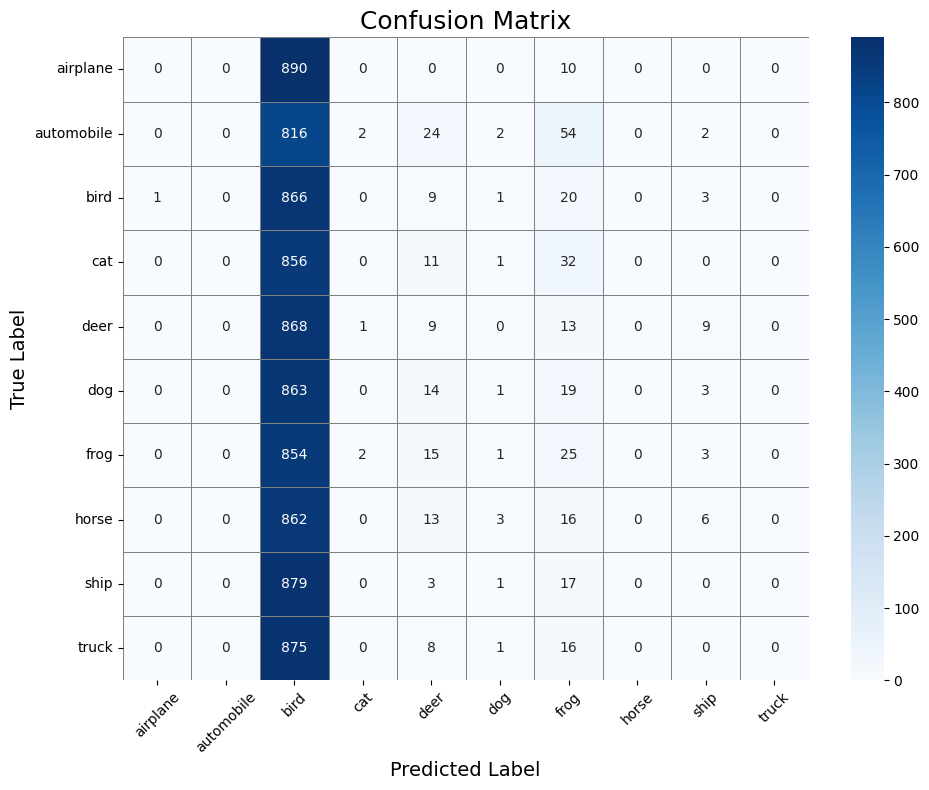

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='gray')
    plt.title("Confusion Matrix", fontsize=18)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(y_true, y_pred, class_names)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


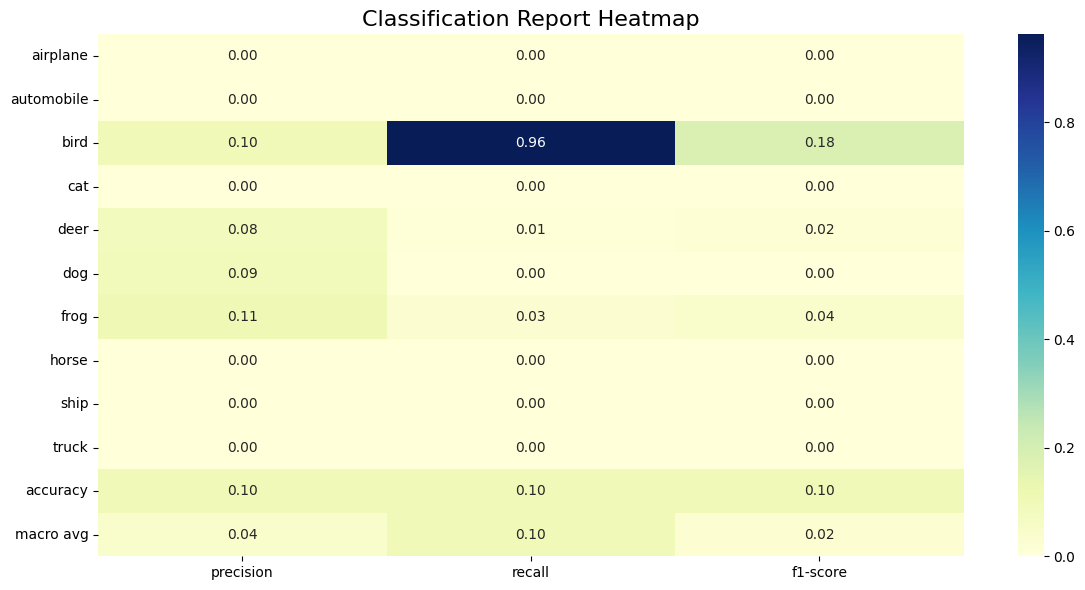

In [20]:
def plot_classification_report(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, output_dict=True, target_names=labels)
    df = pd.DataFrame(report).iloc[:-1, :-1].T  # Ignore support and avg
    plt.figure(figsize=(12, 6))
    sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title("Classification Report Heatmap", fontsize=16)
    plt.tight_layout()
    plt.show()


plot_classification_report(y_true, y_pred, class_names)

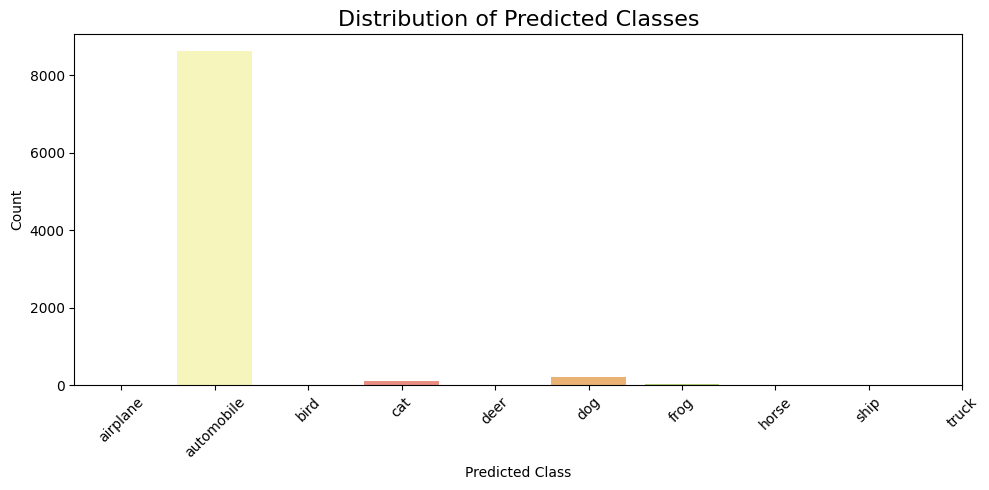

In [21]:
def plot_prediction_distribution(y_pred, class_names):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=y_pred, palette="Set3")
    plt.title("Distribution of Predicted Classes", fontsize=16)
    plt.xlabel("Predicted Class")
    plt.ylabel("Count")
    plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
    plt.tight_layout()
    plt.show()

plot_prediction_distribution(y_pred, class_names)

## **Training History Saving & Visualization**
This section focuses on saving and loading the training history and visualizing accuracy and loss over epochs.

<details>
<summary><b>Functionality Overview</b></summary>

- **Saving Training History**:
  - `save_history(history, filename)`:
    - Saves the training history (accuracy, loss, etc.) into a JSON file.
    - Helps in resuming plots and analysis without retraining the model.
  
- **Loading Training History**:
  - `load_history(filename)`:
    - Loads the previously saved training history for plotting and further analysis.

- **Plotting Training Curves**:
  - `plot_final_training_curves(history)`:
    - Plots **Accuracy** and **Loss** curves for both training and validation sets over epochs.
    - Helps identify overfitting/underfitting trends.
  
- **Workflow**:
  - Checks if a training history file exists:
    - If yes: Loads the history.
    - If no: Trains the model, saves the history, and then loads it.
  - Plots final training curves.

</details>



In [22]:
import json
import os

def save_history(history, filename='training_history.json'):
    with open(filename, 'w') as f:
        json.dump(history.history, f)

def load_history(filename='training_history.json'):
    with open(filename, 'r') as f:
        history_dict = json.load(f)
    return history_dict


In [23]:
def plot_final_training_curves(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    sns.lineplot(x=epochs, y=acc, label='Train Accuracy', ax=axs[0], color='blue')
    sns.lineplot(x=epochs, y=val_acc, label='Val Accuracy', ax=axs[0], color='green')
    axs[0].set_title("📈 Accuracy Over Epochs", fontsize=14)
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Accuracy")

    sns.lineplot(x=epochs, y=loss, label='Train Loss', ax=axs[1], color='red')
    sns.lineplot(x=epochs, y=val_loss, label='Val Loss', ax=axs[1], color='orange')
    axs[1].set_title("📉 Loss Over Epochs", fontsize=14)
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")

    plt.tight_layout()
    plt.show()


🚀 Training the model...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

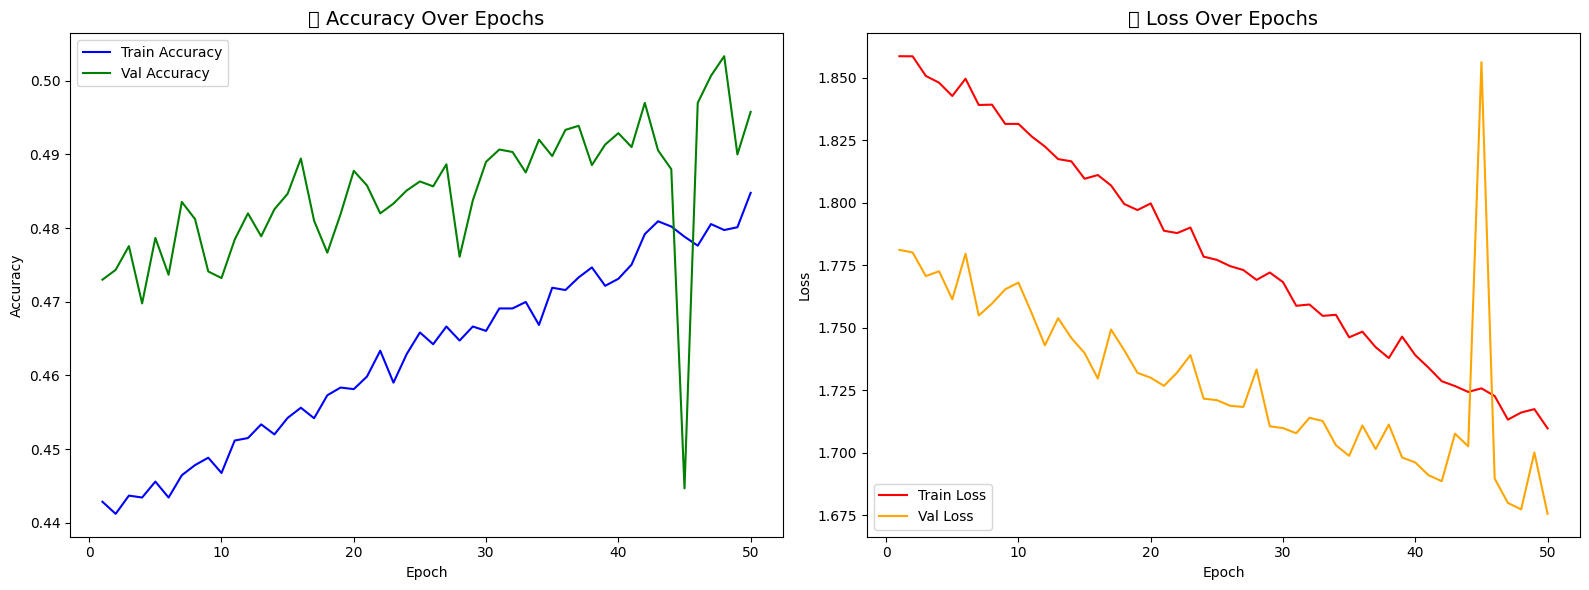

In [24]:
history_filename = "training_history.json"
history_file = os.path.join(folder_dir, history_filename)

if os.path.exists(history_file):
    print("⏳ Loading saved training history...")
    history_dict = load_history(history_file)
else:
    print("🚀 Training the model...")
    history = best_model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        verbose=0,
        batch_size=64,
        epochs=50,
    )
    save_history(history, history_file)
    history_dict = history.history

plot_final_training_curves(history_dict)


## **Model Evaluation & Grid Search Results**

This section is focused on evaluating multiple models with different hyperparameters and visualizing the results using grid search.

<details>
<summary><b>Functionality Overview</b></summary>

- **Saving and Loading Results**:
  - `save_results(results, filename)`:
    - Saves evaluation metrics for each model (accuracy, precision, recall, F1, F2, etc.) into a JSON file for later use.
  - `load_results(filename)`:
    - Loads saved evaluation results from a JSON file for further analysis.

- **Model Evaluation**:
  - The script iterates over all the models saved in the directory (`SAVE_DIR`) and evaluates each using the test dataset.
  - Metrics include:
    - **Accuracy**: Measures the percentage of correctly classified instances.
    - **Precision**: Measures the ability to correctly identify positive instances.
    - **Recall**: Measures the ability to identify all positive instances.
    - **F1 Score**: The harmonic mean of precision and recall.
    - **F2 Score**: Focuses more on recall, giving it a higher weight than precision.

- **Hyperparameter Extraction**:
  - Hyperparameters (optimizer, learning rate, dropout rate, L2 regularization) are extracted from the model's filename for reference.

- **Visualization of Results**:
  - `plot_gridsearch_results(results_list)`:
    - Creates a barplot of **Accuracy** scores for each model's hyperparameter configuration.
    - Helps in comparing the performance of different hyperparameter settings.

</details>



In [25]:
import json

def save_results(results, filename):
    with open(filename, 'w') as f:
        json.dump(results, f, indent=2)

def load_results(filename):
    with open(filename, 'r') as f:
        return json.load(f)


In [26]:
import os
import re
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model

SAVE_DIR = folder_dir + "MLP_CIFAR10_Models"
results_path = os.path.join(folder_dir, "cifar10_mlp_eval_results.json")

if os.path.exists(results_path):
    print("📂 Loading saved results from file...")
    results_list = load_results(results_path)
else:
    results_list = []
    model_files = [f for f in os.listdir(SAVE_DIR) if f.endswith('.keras')]

    for file in model_files:
        model_path = os.path.join(SAVE_DIR, file)
        print(f"📦 Loading model: {file}")

        try:
            model = load_model(model_path)
        except Exception as e:
            print(f"❌ Failed to load {file}: {e}")
            continue

       # Prediction on test data
        y_pred_probs = model.predict(x_test, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = np.argmax(y_test, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        f2 = fbeta_score(y_true, y_pred, average='weighted', beta=2)

        # Extract hyperparameters from file name
        match = re.match(r"mlp_opt-(.*?)_lr-(.*?)_dr-(.*?)_l2-(.*?)\.keras", file)
        if match:
            optimizer, lr, dr, l2 = match.groups()
            results_list.append({
                'model_name': file,
                'optimizer': optimizer,
                'learning_rate': float(lr),
                'dropout_rate': float(dr),
                'l2_reg': float(l2),
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'f2': f2
            })
        else:
            print(f"⚠️ Couldn't parse filename: {file}")


📦 Loading model: mlp_opt-sgd_lr-0.001_dr-0.3_l2-0.0001.keras
📦 Loading model: mlp_opt-adam_lr-0.0005_dr-0.5_l2-0.001.keras


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


📦 Loading model: mlp_opt-adam_lr-0.0005_dr-0.5_l2-0.0001.keras
📦 Loading model: mlp_opt-adam_lr-0.0005_dr-0.3_l2-0.0001.keras
📦 Loading model: mlp_opt-sgd_lr-0.001_dr-0.3_l2-0.001.keras
📦 Loading model: mlp_opt-sgd_lr-0.0005_dr-0.3_l2-0.0001.keras
📦 Loading model: mlp_opt-sgd_lr-0.0005_dr-0.3_l2-0.001.keras
📦 Loading model: mlp_opt-adam_lr-0.0005_dr-0.3_l2-0.001.keras
📦 Loading model: mlp_opt-adam_lr-0.001_dr-0.3_l2-0.0001.keras
📦 Loading model: mlp_opt-sgd_lr-0.0005_dr-0.5_l2-0.001.keras
📦 Loading model: mlp_opt-adam_lr-0.001_dr-0.5_l2-0.001.keras
📦 Loading model: mlp_opt-sgd_lr-0.0005_dr-0.5_l2-0.0001.keras
📦 Loading model: mlp_opt-adam_lr-0.001_dr-0.3_l2-0.001.keras
📦 Loading model: mlp_opt-sgd_lr-0.001_dr-0.5_l2-0.0001.keras
📦 Loading model: mlp_opt-adam_lr-0.001_dr-0.5_l2-0.0001.keras
📦 Loading model: mlp_opt-sgd_lr-0.001_dr-0.5_l2-0.001.keras


/tmp/ipykernel_13/816673780.py:15: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


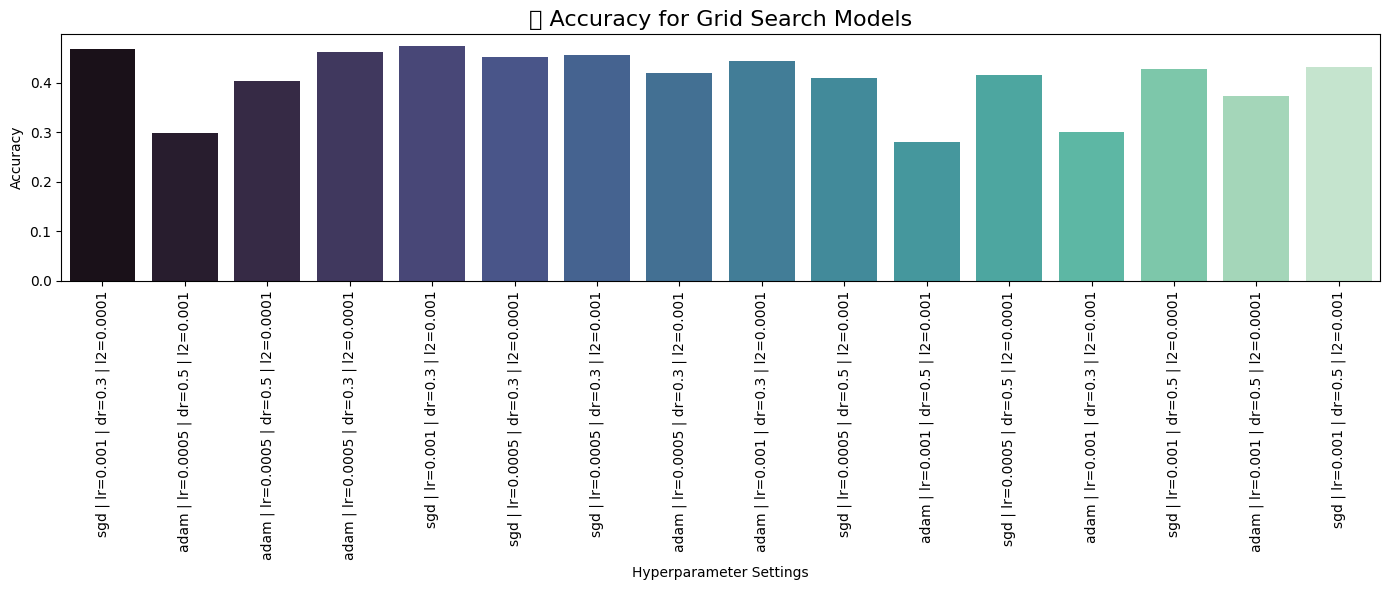

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_gridsearch_results(results_list):
    df = pd.DataFrame(results_list)
    df["label"] = df.apply(lambda row: f"{row['optimizer']} | lr={row['learning_rate']} | dr={row['dropout_rate']} | l2={row['l2_reg']}", axis=1)

    plt.figure(figsize=(14, 6))
    sns.barplot(x="label", y="accuracy", data=df, palette="mako")
    plt.title("🚀 Accuracy for Grid Search Models", fontsize=16)
    plt.xticks(rotation=90)
    plt.xlabel("Hyperparameter Settings")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

plot_gridsearch_results(results_list)


## **Visualizing Model Predictions**

This function visualizes the model's predictions on a random set of test images. It compares the predicted and true labels for each image. Correct predictions are shown in **green**, while misclassifications are shown in **red**.

### **Usage:**
- `model`: The trained model for predictions.
- `x_test`: Test images.
- `y_test`: True labels.
- `class_names`: Class labels.
- `num_images`: Number of images to display

The images are displayed in a grid with their true and predicted labels.


In [28]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, x_test, y_test, class_names, num_images=24):
    plt.figure(figsize=(12, 12))

    # Select a few random samples from the test data
    indices = np.random.choice(len(x_test), num_images, replace=False)
    images = x_test[indices]
    true_labels = np.argmax(y_test[indices], axis=1)

    # Model prediction
    preds = model.predict(images)
    predicted_labels = np.argmax(preds, axis=1)

    for i in range(num_images):
        plt.subplot(8, 8, i+1)
        plt.imshow(images[i])
        plt.axis('off')

        true_label = class_names[true_labels[i]]
        pred_label = class_names[predicted_labels[i]]

        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


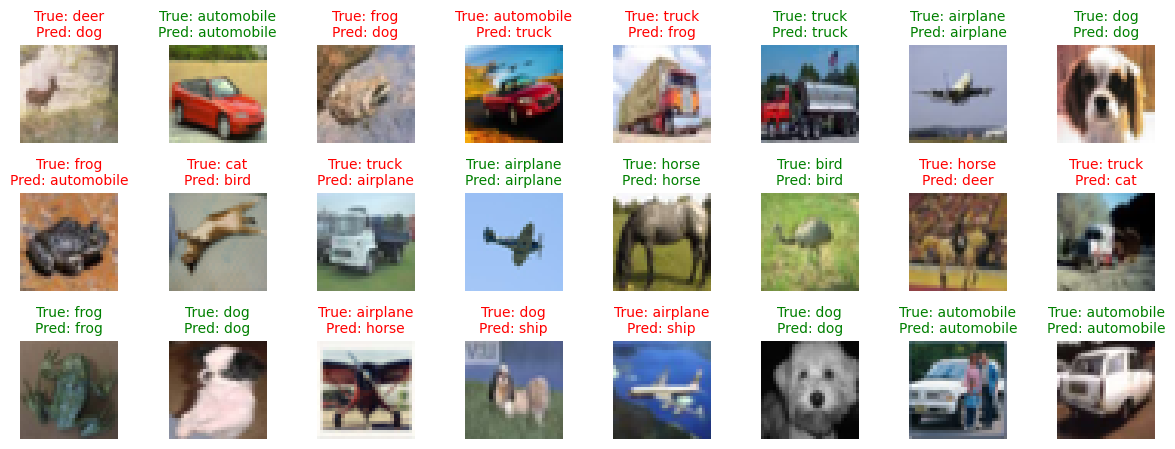

In [29]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

visualize_predictions(best_model, x_test, y_test, class_names)
